# Zurich Instruments Lock-In MFLI Data Aquesition

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

In [3]:
import time

In [4]:
import matplotlib.pyplot as plt

In [5]:
from zhinst import ziPython as zhinst_core

In [6]:
import qupulse

In [7]:
from qupulse.hardware.dacs.mfli import MFLIDAQ

z:\git\qupulse\qupulse\hardware\awgs\tektronix.py:13: UserWarning: Could not import Tektronix driver backend. If you wish to use it execute qupulse.hardware.awgs.install_requirements('tektronix')
  warnings.warn("Could not import Tektronix driver backend. "


In [8]:
my_lockin = MFLIDAQ(device_serial="dev3442", device_interface="PCIe", data_server_addr="192.168.53.202")

In [9]:
my_lockin.assumed_minimal_sample_rate = 1.
my_lockin.assumed_minimal_sample_rate = None

In [10]:
my_lockin_channels = {
    "R": ["demods/0/sample.R"],
    "X": ["demods/0/sample.X"],
    "Y": ["demods/0/sample.Y"],
    "A": ["auxins/0/sample.AuxIn0.avg"],
    "many": ["demods/0/sample.R", "auxins/0/sample.AuxIn0.avg", "demods/0/sample.X", "demods/0/sample.Y"]
}

In [11]:
for k, v in my_lockin_channels.items():
    my_lockin.register_measurement_channel(program_name=None, channel_path=v, window_name=k)

In [12]:
my_lockin.programs[None]

{'channel_mapping': {'R': {'demods/0/sample.R'},
  'X': {'demods/0/sample.X'},
  'Y': {'demods/0/sample.Y'},
  'A': {'auxins/0/sample.AuxIn0.avg'},
  'many': {'auxins/0/sample.AuxIn0.avg',
   'demods/0/sample.R',
   'demods/0/sample.X',
   'demods/0/sample.Y'}}}

In [13]:
my_lockin.register_measurement_windows(program_name="test", windows={"A": (np.array([0, 3])*1, np.array([1, 10])*1), "many": (np.array([0, 2, 4])*1e-3, np.array([1, 4, 6.1])*1e-3)})

In [14]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}},
 'test': {'windows': {'A': (array([0, 3]), array([ 1, 10])),
   'many': (array([0.   , 0.002, 0.004]), array([0.001 , 0.004 , 0.0061]))},
  'windows_from_start_max': {'A': 13, 'many': 0.0101},
  'all_channels': {'auxins/0/sample.auxin0.avg',
   'demods/0/sample.r',
   'demods/0/sample.x',
   'demods/0/sample.y'}}}

In [15]:
my_lockin.delete_program(program_name="test")

In [16]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}}}

## Defining a simple qupulse pulse with a measurement window.

In [17]:
from qupulse.pulses.plotting import plot

In [18]:
red_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("1*dt", 4, 'hold'),
    ("4*dt", .5, 'linear'),
    ("5*dt", 2, 'hold'),
    ("6*dt", .5, 'hold'),
    ("15*dt", .5, 'jump'),
]})

In [19]:
green_pulse = qupulse.pulses.SequencePT(*[
    qupulse.pulses.FunctionPT(".1", "6*dt", channel="green"),
    qupulse.pulses.FunctionPT(".1+(t/dt)**2*.9", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("1+sin((t/dt)*2*pi)*exp(-((t/dt)-2)**2)", "5*dt", channel="green"),
    qupulse.pulses.FunctionPT("1", "1*dt", channel="green"),
    qupulse.pulses.FunctionPT("0", "1*dt", channel="green"),
]
)

In [20]:
measured_pt = qupulse.pulses.PointPT([("0*dt", 0), ("0*dt", 1), ("15*dt", 1), ("15*dt", 0)],
                      channel_names=("trigger_out",),
                      measurements=[('A', "dt*3", "dt*1.5"), ('A', "dt*12", "dt*3"), ('R', "dt*6.5", "dt*1.4"), ('R', "dt*14", "dt*1"), ('T', "dt*10", "dt*3")])

In [21]:
combined_pulse = red_pulse+green_pulse+measured_pt

z:\git\qupulse\qupulse\pulses\arithmetic_pulse_template.py:72: ImplicitAtomicityInArithmeticPT: ArithmeticAtomicPulseTemplate treats all operands as if they are atomic. You can silence this warning by passing `silent_atomic=True` or by ignoring this category.
  category=ImplicitAtomicityInArithmeticPT)


In [22]:
print(combined_pulse.measurement_names)
print(combined_pulse.measurement_declarations)
print(combined_pulse.measurement_parameters)

{'R', 'T', 'A'}
[]
set()


In [23]:
combined_pulse.get_measurement_windows

<bound method ArithmeticAtomicPulseTemplate.get_measurement_windows of ((TablePulseTemplate(entries={'red': [(0, 0, 'hold'), ('1*dt', 4, 'hold'), ('4*dt', 0.5, 'linear'), ('5*dt', 2, 'hold'), ('6*dt', 0.5, 'hold'), ('15*dt', 0.5, 'jump')]},parameter_constraints=[],measurements=[]) '+' SequencePulseTemplate(subtemplates=[FunctionPulseTemplate(duration_expression=ExpressionScalar('6*dt'),expression=ExpressionScalar('.1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1*dt'),expression=ExpressionScalar('.1+(t/dt)**2*.9'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('1*dt'),expression=ExpressionScalar('1'),channel='green',measurements=[],parameter_constraints=[]), FunctionPulseTemplate(duration_expression=ExpressionScalar('5*dt'),expression=ExpressionScalar('1+sin((t/dt)*2*pi)*exp(-((t/dt)-2)**2)'),channel='green',measurements=[],parameter_constra

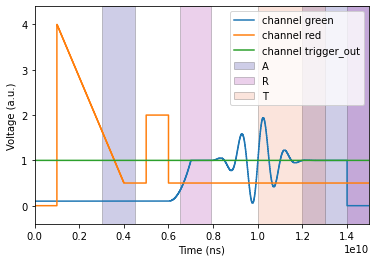

In [24]:
plot(combined_pulse, sample_rate=1e-7, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e9}) # combined_pulse.measurement_names
plt.show()

In [25]:
idle_pulse = qupulse.pulses.TablePT({"red": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "green": [
    ("0*dt", 0),
    ("5*dt", 0),
],
                                     "trigger_out": [
    ("0*dt", 0),
    ("5*dt", 0),
]})

In [26]:
rep = qupulse.pulses.repetition_pulse_template.RepetitionPulseTemplate(
    body=qupulse.pulses.SequencePT(combined_pulse, idle_pulse),
    repetition_count=10
)

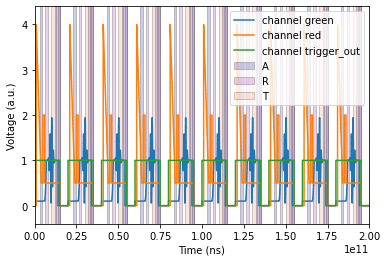

In [27]:
plot(rep, sample_rate=1e-7, plot_measurements=combined_pulse.measurement_names, parameters={"dt": 1e9})
plt.show()

## Execution

1. map output channels to dummy instrument
2. arm scan and see if everything works

In [28]:
from qupulse.utils.types import TimeType

In [29]:
from qupulse.hardware.awgs.virtual import VirtualAWG

In [30]:
from qupulse.hardware.setup import HardwareSetup, MeasurementMask, PlaybackChannel

In [31]:
my_awg = VirtualAWG("awg", channels=3)

In [32]:
setup = HardwareSetup()

In [33]:
for n in my_lockin.programs[None]["channel_mapping"].keys():
    setup.set_measurement(f"{n}", MeasurementMask(my_lockin, n))

In [34]:
for i, c in enumerate(["red", "green", "trigger_out"]):
    setup.set_channel(f"{c}", PlaybackChannel(my_awg, i))

In [35]:
test_program = combined_pulse.create_program(measurement_mapping={"A":"A", "R":"R", "T":"X"},parameters={"dt": 1e9})

In [36]:
setup.register_program('test', test_program, run_callback=lambda *a, **b: my_lockin.force_trigger(None), update=True)

In [37]:
15e-9*1674.107177734375

2.5111607666015624e-05

In [38]:
my_lockin.programs

{None: {'channel_mapping': {'R': {'demods/0/sample.R'},
   'X': {'demods/0/sample.X'},
   'Y': {'demods/0/sample.Y'},
   'A': {'auxins/0/sample.AuxIn0.avg'},
   'many': {'auxins/0/sample.AuxIn0.avg',
    'demods/0/sample.R',
    'demods/0/sample.X',
    'demods/0/sample.Y'}}},
 'test': {'windows': {'X': (array([1.e+10]), array([3.e+09])),
   'R': (array([6.5e+09, 1.4e+10]), array([1.4e+09, 1.0e+09])),
   'A': (array([3.0e+09, 1.2e+10]), array([1.5e+09, 3.0e+09]))},
  'windows_from_start_max': {'X': 13000000000.0,
   'R': 15000000000.0,
   'A': 15000000000.0},
  'all_channels': {'auxins/0/sample.auxin0.avg',
   'demods/0/sample.r',
   'demods/0/sample.x'}}}

In [98]:
setup.run_program("test")

z:\git\qupulse\qupulse\hardware\dacs\mfli.py:344: UserWarning: The channel auxins/0/sample.auxin0.avg does not have an interface for enabling it. If needed, this can be done using the web interface.
  warnings.warn(f"The channel {c} does not have an interface for enabling it. If needed, this can be done using the web interface.")


Will record 25112 samples in 15.000000000000002s!
MFLI returns a total record time of {'duration': array([15.00023467])}s


In [99]:
data = my_lockin.measure_program([""])

Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
Waiting for device dev3442 to finish the acquisition.
{'buffercount': array([77], dtype=int64), 'dev3442': {'auxins': {'0': {'sample.aux

In [74]:
data

{'/dev3442/auxins/0/sample.auxin0.avg': [<xarray.DataArray '/dev3442/auxins/0/sample.auxin0.avg' (row: 1, col: 25112)>
  array([[-0.00211383, -0.00209682, -0.00207982, ..., -0.00121121,
          -0.00121688, -0.00122255]])
  Coordinates:
      timestamp  (row, col) float64 4.482e+12 4.482e+12 ... 4.497e+12 4.497e+12
  Dimensions without coordinates: row, col
  Attributes:
      systemtime:        [1664528424329287]
      createdtimestamp:  [268898909736]
      changedtimestamp:  [268898909736]
      flags:             [825]
      moduleflags:       [0]
      chunksizebytes:    [0]
      name:              003 11:00:24.3286
      status:            [0]
      groupindex:        [0]
      color:             [0]
      activerow:         [0]
      triggernumber:     [0]
      gridrows:          [1]
      gridcols:          [25112]
      gridmode:          [4]
      gridoperation:     [1]
      griddirection:     [0]
      gridrepetitions:   [1]
      gridcoldelta:      [0.00059733]
      g

In [75]:
for e in data['/dev3442/auxins/0/sample.auxin0.avg'][0]["timestamp"].values[0, :20]:
    print(e)
print("---")
for e in data['/dev3442/auxins/0/sample.auxin0.avg'][0]["timestamp"].values[0, -20:]:
    print(e)

4481648300933.333
4481648898266.667
4481649495600.0
4481650092933.333
4481650690266.667
4481651287600.0
4481651884933.333
4481652482266.667
4481653079600.0
4481653676933.333
4481654274266.667
4481654871600.0
4481655468933.333
4481656066266.667
4481656663600.0
4481657260933.333
4481657858266.667
4481658455600.0
4481659052933.333
4481659650266.667
---
4496636588933.334
4496637186266.666
4496637783600.0
4496638380933.333
4496638978266.667
4496639575600.0
4496640172933.333
4496640770266.667
4496641367600.0
4496641964933.333
4496642562266.667
4496643159600.0
4496643756933.333
4496644354266.667
4496644951600.0
4496645548933.333
4496646146266.667
4496646743600.0
4496647340933.333
4496647938266.667


In [63]:
(130556892296-129657379976)*1e-9

0.89951232

In [76]:
for e in data['/dev3442/auxins/0/sample.auxin0.avg'][0].values[0, :40]:
    print(e)

-0.0021138295076801594
-0.002096822800171233
-0.0020798160926623066
-0.00206280938515338
-0.0020458026776444538
-0.0020287959701355274
-0.002011789262626601
-0.0019947825551176745
-0.001977775847608748
-0.0019607691400998217
-0.0019437624325908953
-0.001926755725081969
-0.0019097490175730425
-0.001892742310064116
-0.0018757356025551897
-0.0018587288950462633
-0.0018417221875373369
-0.0018247154800284104
-0.001807708772519484
-0.0017907020650105576
-0.0017736953575016312
-0.0017566886499927048
-0.0017396819424837784
-0.001722675234974852
-0.0017056685274659256
-0.0016886618199569992
-0.0016716551124480727
-0.0016572554041315024
-0.001651586501628527
-0.0016459175991255515
-0.001640248696622576
-0.0016345797941196005
-0.001628910891616625
-0.0016232419891136496
-0.0016175730866106741
-0.0016119041841076986
-0.0016062352816047232
-0.0016005663791017477
-0.0015948974765987722
-0.0015892285740957968


In [107]:
extracted_data = my_lockin._parse_data(data, program_name="test")

/dev3442/demods/0/sample.x
time_of_trigger=[5.27302317e+12]
extracted_data=[<xarray.DataArray '/dev3442/demods/0/sample.x' (row: 1, col: 5022)>
array([[ 8.20515335e-08, -1.37302456e-07, -2.23006770e-07, ...,
        -2.51220898e-07, -8.52887497e-08, -8.56558814e-08]])
Coordinates:
    time     (row, col) float64 1e+10 1e+10 1e+10 ... 1.3e+10 1.3e+10 1.3e+10
Dimensions without coordinates: row, col
Attributes:
    systemtime:        [1664529215403471]
    createdtimestamp:  [316381462056]
    changedtimestamp:  [316381462056]
    flags:             [1849]
    moduleflags:       [0]
    chunksizebytes:    [0]
    name:              004 11:13:35.4017
    status:            [0]
    groupindex:        [0]
    color:             [0]
    activerow:         [0]
    triggernumber:     [0]
    gridrows:          [1]
    gridcols:          [25112]
    gridmode:          [4]
    gridoperation:     [1]
    griddirection:     [0]
    gridrepetitions:   [1]
    gridcoldelta:      [0.00059733]
    gri

In [105]:
def plot_windows(data):
    for j, w in enumerate(data.keys()):
        for i, c in enumerate(data[w].keys()):
            for e in data[w][c]:
                print(e["time"].values, e.values)
                plt.plot(e["time"].values.T, e.values.T, color=f"C{j}")
    plt.show()

[[1.00003600e+10 1.00009573e+10 1.00015547e+10 ... 1.29983760e+10
  1.29989733e+10 1.29995707e+10]] [[ 8.20515335e-08 -1.37302456e-07 -2.23006770e-07 ... -2.51220898e-07
  -8.52887497e-08 -8.56558814e-08]]
[[6.50058400e+09 6.50118133e+09 6.50177867e+09 ... 7.89834400e+09
  7.89894133e+09 7.89953867e+09]] [[5.09070137e-07 4.36690684e-07 4.20131474e-07 ... 5.52220621e-07
  5.07130206e-07 2.38696738e-07]]
[[1.40001040e+10 1.40007013e+10 1.40012987e+10 ... 1.49982480e+10
  1.49988453e+10 1.49994427e+10]] [[4.39980625e-07 5.04697280e-07 4.95701644e-07 ... 2.04461446e-07
  3.65230061e-07 5.32911742e-07]]
[[3.00021067e+09 3.00080800e+09 3.00140533e+09 ... 4.49832267e+09
  4.49892000e+09 4.49951733e+09]] [[-0.00120247 -0.00121381 -0.00122515 ... -0.00054094 -0.00051259
  -0.00048425]]
[[1.20002320e+10 1.20008293e+10 1.20014267e+10 ... 1.49289573e+10
  1.49295547e+10 1.49301520e+10]] [[-0.00106838 -0.00109105 -0.00111373 ... -0.00232198 -0.00232198
  -0.00232198]]


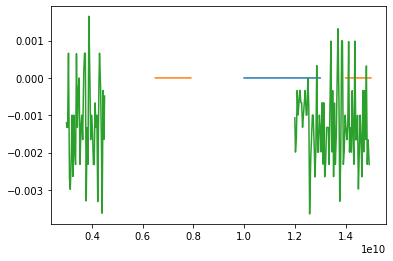

In [108]:
plot_windows(extracted_data)

In [50]:
%debug

> c:\users\surrey\miniconda3\envs\py37\lib\site-packages\xarray\core\indexing.py(83)group_indexers_by_index()
     81         except KeyError:
     82             if key in data_obj.coords:
---> 83                 raise KeyError(f"no index found for coordinate {key}")
     84             elif key not in data_obj.dims:
     85                 raise KeyError(f"{key} is not a valid dimension or coordinate")

ipdb> u
> c:\users\surrey\miniconda3\envs\py37\lib\site-packages\xarray\core\indexing.py(110)remap_label_indexers()
    108 
    109     indexes, grouped_indexers = group_indexers_by_index(
--> 110         data_obj, indexers, method, tolerance
    111     )
    112 

ipdb> u
> c:\users\surrey\miniconda3\envs\py37\lib\site-packages\xarray\core\coordinates.py(422)remap_label_indexers()
    420 
    421     pos_indexers, new_indexes = indexing.remap_label_indexers(
--> 422         obj, v_indexers, method=method, tolerance=tolerance
    423     )
    424     # attach indexer's coordinate 

In [39]:
data[0][0].values

KeyError: 0

In [ ]:
data[0][0].timestamp.values

In [43]:
import matplotlib.pyplot as plt

In [72]:
data['/dev3442/demods/0/sample.r'][0]

<xarray.DataArray '/dev3442/demods/0/sample.r' (col: 1, row: 25112)>
array([[7.03522854e-07, 6.92340419e-07, 7.21439685e-07, ...,
        3.06968651e-07, 3.77702425e-07, 4.19837064e-07]])
Coordinates:
    timestamp  (col, row) uint64 2303061427353 2303061463193 ... 2303961405593
Dimensions without coordinates: col, row
Attributes:
    systemtime:        [1664476581306703]
    createdtimestamp:  [2303061439033]
    changedtimestamp:  [2303061439033]
    flags:             [1849]
    moduleflags:       [0]
    chunksizebytes:    [0]
    name:              009 20:36:21.3054
    status:            [0]
    groupindex:        [0]
    color:             [0]
    activerow:         [0]
    triggernumber:     [0]
    gridrows:          [1]
    gridcols:          [25112]
    gridmode:          [4]
    gridoperation:     [1]
    griddirection:     [0]
    gridrepetitions:   [1]
    gridcoldelta:      [0.00059733]
    gridcoloffset:     [-0.001]
    gridrowdelta:      [1.]
    gridrowoffset:     [0.]
    bandwidth:         [nan]
    center:            [0.]
    nenbw:             [nan]

In [48]:
21763/1.674e3

13.000597371565114

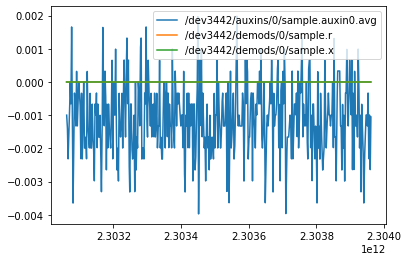

In [71]:
for name, d in data.items():
    plt.plot(d[0].timestamp.values.reshape((-1)), d[0].values.reshape((-1)), label=d[0].name)
plt.legend()
plt.show()

In [68]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(385)measure_program()
    383                                                         channel_name = f"/{device_name}/{input_name}/{signal_name}/{final_level_name}"
    384 							channel_data = xr.DataArray(
--> 385                                                                 data=final_level_data["value"],
    386                                                                 cords={'timestamp': final_level_data['timestamp']},
    387                                                                 dims=['col', 'row'],

ipdb> final_level_data
[{'header': {'systemtime': array([1664382261279112], dtype=uint64), 'createdtimestamp': array([1312194966056], dtype=uint64), 'changedtimestamp': array([1312194966056], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '007 18:24:21.2784', 'status': array([0], dtype=uint32), 'groupindex': array([0], dty

In [55]:
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()}")

{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{}
Progress [0.]
{'dev3442': {'auxins': {'0': {'sample.auxin0.avg': [{'header': {'systemtime': array([1664381184448982], dtype=uint64), 'createdtimestamp': array([1247600892456], dtype=uint64), 'changedtimestamp': array([1247600892456], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '002 18:06:24.4482', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'triggernumber': array([0], dtype=uint64), 'gridrows': array([1], dtype=uint32), 'gridcols': array([21763], dtype=uint32), 'gridmode': array([4], dty

In [63]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(376)measure_program()
    374 
    375                 for device_name, device_data in data.items():
--> 376                         for input_name, input_data in device_data.items():
    377                                 for signal_name, signal_data in input_data.items():
    378                                         print(list(signal_data.keys()))

ipdb> device_data
array([0], dtype=int64)
ipdb> data
{'dev3442': {'auxins': {'0': {'sample.auxin0.avg': [{'header': {'systemtime': array([1664381558471132], dtype=uint64), 'createdtimestamp': array([1270042036776], dtype=uint64), 'changedtimestamp': array([1270042036776], dtype=uint64), 'flags': array([825], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '005 18:12:38.4705', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'trigge

In [192]:
my_lockin.daq_read_return

{'awgcontrol': array([0], dtype=int64),
 'bandwidth': array([0.]),
 'bitmask': array([1], dtype=int64),
 'bits': array([1], dtype=int64),
 'buffercount': array([2], dtype=int64),
 'buffersize': array([0.2]),
 'clearhistory': array([0], dtype=int64),
 'count': array([1], dtype=int64),
 'delay': array([-0.001]),
 'device': [''],
 'duration': array([0.]),
 'edge': array([1], dtype=int64),
 'enable': array([1], dtype=int64),
 'endless': array([0], dtype=int64),
 'eventcount': {'mode': array([1], dtype=int64)},
 'fft': {'absolute': array([0], dtype=int64),
  'window': array([1], dtype=int64)},
 'findlevel': array([0], dtype=int64),
 'flags': array([8], dtype=int64),
 'forcetrigger': array([0], dtype=int64),
 'grid': {'cols': array([21763], dtype=int64),
  'direction': array([0], dtype=int64),
  'mode': array([4], dtype=int64),
  'overwrite': array([0], dtype=int64),
  'repetitions': array([1], dtype=int64),
  'rowrepetition': array([0], dtype=int64),
  'rows': array([1], dtype=int64),
  'wa

In [174]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(357)measure_program()
    355 
    356                 data = self.daq.read()
--> 357                 self.daq_read_return.update(data)
    358 
    359                 print(data)

ipdb> data
{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
ipdb> r


In [123]:
my_lockin.clear()

In [145]:
my_lockin.daq.read(flat=True)

{}

In [119]:
my_lockin.daq.read()

{}

In [110]:
my_lockin.force_trigger(None)

In [111]:
dir(my_lockin.daq)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'clear',
 'execute',
 'finish',
 'finished',
 'get',
 'getDouble',
 'getInt',
 'getString',
 'getStringUnicode',
 'help',
 'listNodes',
 'listNodesJSON',
 'progress',
 'read',
 'save',
 'set',
 'subscribe',
 'trigger',
 'unsubscribe']

In [44]:
my_lockin.daq.finish()

In [45]:
my_lockin.daq.progress()

array([1.])

In [202]:
my_lockin.daq.set('forcetrigger', 1)

In [114]:
my_lockin.daq.progress()

array([0.])

In [117]:
my_lockin.daq.read()

{'triggered': array([0], dtype=int64)}

In [116]:
my_lockin.daq.finish()

In [193]:
my_lockin.daq.execute()

In [9]:
import time

In [32]:
my_lockin.daq.clear()
my_lockin.daq = my_lockin.api_session.dataAcquisitionModule()

In [33]:
my_lockin.api_session.setDebugLevel(0)

In [37]:
my_lockin.daq.set('device', 'dev3442')
# my_lockin.daq.set('save/directory', 'C:\\Users\\Surrey\\Documents\\Zurich Instruments\\LabOne\\WebServer')
my_lockin.daq.set('type', 1)
my_lockin.daq.set('triggernode', '/dev3442/demods/0/sample.AuxIn0')
my_lockin.daq.set('endless', 0)
my_lockin.daq.set('grid/cols', 1000)
# my_lockin.daq.subscribe('/dev3442/demods/0/sample.R.avg')
my_lockin.daq.subscribe('/dev3442/demods/0/sample.R')
my_lockin.daq.subscribe('/dev3442/demods/0/sample.X')
my_lockin.daq.execute()
my_lockin.daq.set('forcetrigger', 1)
result = 0
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()} %\r")

{'forcetrigger': array([0], dtype=int64), 'triggered': array([1], dtype=int64)}
Progress [0.] %
{'dev3442': {'demods': {'0': {'sample.r': [{'header': {'systemtime': array([1664380454830777], dtype=uint64), 'createdtimestamp': array([1204630954536], dtype=uint64), 'changedtimestamp': array([1204630954536], dtype=uint64), 'flags': array([1849], dtype=uint32), 'moduleflags': array([0], dtype=uint32), 'chunksizebytes': array([0], dtype=uint64), 'name': '100 17:54:14.8306', 'status': array([0], dtype=uint32), 'groupindex': array([0], dtype=uint32), 'color': array([0], dtype=uint32), 'activerow': array([0], dtype=uint32), 'triggernumber': array([0], dtype=uint64), 'gridrows': array([1], dtype=uint32), 'gridcols': array([1000], dtype=uint32), 'gridmode': array([4], dtype=uint32), 'gridoperation': array([1], dtype=uint32), 'griddirection': array([0], dtype=uint32), 'gridrepetitions': array([1], dtype=uint32), 'gridcoldelta': array([0.00059733]), 'gridcoloffset': array([-0.001]), 'gridrowdelta'

In [29]:
while not my_lockin.daq.finished():
    time.sleep(1)
    result = my_lockin.daq.read()
    print(result)
    print(f"Progress {my_lockin.daq.progress()} %\r")

RuntimeError: Timeout during set in dataAcquisitionModule module.

In [35]:
my_lockin.daq.finish()
my_lockin.daq.unsubscribe('*')

In [31]:
my_lockin.daq.clear()

In [78]:
%debug

> z:\git\qupulse\qupulse\hardware\dacs\mfli.py(270)arm_program()
    268                                 demod = self._get_demod(c)
    269                                 try:
--> 270                                         self.api_session.set(f'/{self.serial}/{demod}/enable', 1)
    271                                 except RuntimeError  as e:
    272                                         raise

ipdb> self.api_session.setInt('/dev3442/demods/0/enable', 0)
ipdb> r
